<a href="https://colab.research.google.com/github/stephaniediamond3/DATA71200/blob/main/Project1_New.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step 1: Find and download a dataset.

In [1]:
# website https://www.cdc.gov/nchs/data_access/VitalStatsOnline.htm
# dta file https://data.nber.org/nvss/natality/dta/

#call data
!wget -O natality2024us.dta https://data.nber.org/nvss/natality/dta/2024/natality2024us.dta



--2025-12-04 01:52:07--  https://data.nber.org/nvss/natality/dta/2024/natality2024us.dta
Resolving data.nber.org (data.nber.org)... 198.71.6.22, 198.71.6.39
Connecting to data.nber.org (data.nber.org)|198.71.6.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 913399671 (871M)
Saving to: ‘natality2024us.dta’

natality2024us.dta  100%[===================>] 871.08M  1.64MB/s    in 8m 51s  

2025-12-04 02:00:58 (1.64 MB/s) - ‘natality2024us.dta’ saved [913399671/913399671]



In [2]:
import pandas as pd
import numpy as np

#Select relevant columns
cols = [
    # Maternal morbidity indicators
    "mm_mtr","mm_plac","mm_rupt","mm_uhyst","mm_aicu",
    # Risk factors
    "rf_pdiab","rf_gdiab","rf_phype","rf_ghype","rf_ehype",
    "rf_ppterm","rf_inftr","rf_fedrg","rf_artec","rf_cesar",
    "rf_cesarn","no_risks",
    # SES proxies
    "meduc","wic","pay_rec",
    # Race/ethnicity
    "mracehisp","mhisp_r","mrace6",
    # Health behaviors
    "bmi_r","cig0_r","precare5",
    # Demographics/pregnancy context
    "mager","dplural","lbo_rec","tbo_rec",
    "priorlive","priordead","priorterm",
    # Gestational age
    "gestrec10"
]

# create df
df = pd.read_stata("natality2024us.dta", columns=cols, convert_categoricals=False)


Create New Vars

In [ ]:
### TRIMMED COPY ###
#from google.colab import drive
#drive.mount('/content/drive')
#df.to_parquet("/content/drive/MyDrive/natality2024_trimmed.parquet", index=False)

### READ BACK IN ###

#from google.colab import drive
#drive.mount('/content/drive')

#import pandas as pd
#df = pd.read_parquet("/content/drive/MyDrive/natality2024_trimmed.parquet")


Mounted at /content/drive


In [3]:
ynu_cols = [
    "mm_mtr","mm_plac","mm_rupt","mm_uhyst","mm_aicu",
    "rf_pdiab","rf_gdiab","rf_phype","rf_ghype","rf_ehype",
    "rf_ppterm","rf_inftr","rf_fedrg","rf_artec","rf_cesar", "wic"
]

# convert Y/N/U/X to 1/0/NaN
map_vals = {"Y": 1, "N": 0, "U": np.nan, "X": np.nan}
df[ynu_cols] = df[ynu_cols].replace(map_vals)

# verify
print(df[ynu_cols].dtypes)
print(df[ynu_cols].isna().sum().sort_values(ascending=False).head())

/tmp/ipython-input-1917949335.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[ynu_cols] = df[ynu_cols].replace(map_vals)


mm_mtr       float64
mm_plac      float64
mm_rupt      float64
mm_uhyst     float64
mm_aicu      float64
rf_pdiab     float64
rf_gdiab     float64
rf_phype     float64
rf_ghype     float64
rf_ehype     float64
rf_ppterm    float64
rf_inftr     float64
rf_fedrg     float64
rf_artec     float64
rf_cesar     float64
wic          float64
dtype: object
rf_fedrg    3549214
rf_artec    3549214
wic           43306
mm_mtr        12078
mm_aicu       12078
dtype: int64


In [4]:
# Define maternal morbidity indicator columns
mm_cols = ["mm_mtr","mm_plac","mm_rupt","mm_uhyst","mm_aicu"]

# SMM composite
df["smm"] = np.where(df[mm_cols].eq(1).any(axis=1), 1, np.nan)
df.loc[df[mm_cols].eq(0).all(axis=1), "smm"] = 0

df["smm"] = df["smm"].astype(float)

print("SMM\n", df["smm"].value_counts(dropna=False))



SMM
 smm
0.0    3570721
1.0      55637
NaN      12078
Name: count, dtype: int64


In [5]:
# check data types and counts
print(df[mm_cols].dtypes)

for col in mm_cols:
    print(f"\n{col} value counts:")
    print(df[col].value_counts(dropna=False))


mm_mtr      float64
mm_plac     float64
mm_rupt     float64
mm_uhyst    float64
mm_aicu     float64
dtype: object

mm_mtr value counts:
mm_mtr
0.0    3605218
1.0      21140
NaN      12078
Name: count, dtype: int64

mm_plac value counts:
mm_plac
0.0    3598112
1.0      28246
NaN      12078
Name: count, dtype: int64

mm_rupt value counts:
mm_rupt
0.0    3624745
NaN      12078
1.0       1613
Name: count, dtype: int64

mm_uhyst value counts:
mm_uhyst
0.0    3624778
NaN      12078
1.0       1580
Name: count, dtype: int64

mm_aicu value counts:
mm_aicu
0.0    3619223
NaN      12078
1.0       7135
Name: count, dtype: int64


Step 2: Divide into a training set and a testing set.

In [6]:
from sklearn.model_selection import train_test_split

# Prep
df_model = df.dropna(subset=["smm"]).copy()

mm_cols = ["mm_mtr","mm_plac","mm_rupt","mm_uhyst","mm_aicu"]
y = df_model["smm"]
X = df_model.drop(columns=["smm"] + mm_cols)

# Train/test split with stratification to preserve SMM balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=66, test_size=0.3, stratify=y
)

# Check shapes/balance
print(X_train.shape, X_test.shape)
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))


(2538450, 29) (1087908, 29)
smm
0.0    0.984658
1.0    0.015342
Name: proportion, dtype: float64
smm
0.0    0.984658
1.0    0.015342
Name: proportion, dtype: float64


Step 3: Explore your training set.

In [7]:
X_train.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2538450 entries, 285186 to 3427017
Data columns (total 29 columns):
 #   Column     Dtype  
---  ------     -----  
 0   rf_pdiab   float64
 1   rf_gdiab   float64
 2   rf_phype   float64
 3   rf_ghype   float64
 4   rf_ehype   float64
 5   rf_ppterm  float64
 6   rf_inftr   float64
 7   rf_fedrg   float64
 8   rf_artec   float64
 9   rf_cesar   float64
 10  rf_cesarn  int8   
 11  no_risks   int8   
 12  meduc      int8   
 13  wic        float64
 14  pay_rec    int8   
 15  mracehisp  int8   
 16  mhisp_r    int8   
 17  mrace6     int8   
 18  bmi_r      int8   
 19  cig0_r     int8   
 20  precare5   int8   
 21  mager      int8   
 22  dplural    int8   
 23  lbo_rec    int8   
 24  tbo_rec    int8   
 25  priorlive  int8   
 26  priordead  int8   
 27  priorterm  int8   
 28  gestrec10  int8   
dtypes: float64(11), int8(18)
memory usage: 276.0 MB


In [13]:
X_train.describe(include="all")

,rf_pdiab,rf_gdiab,rf_phype,rf_ghype,rf_ehype,rf_ppterm,rf_inftr,rf_fedrg,rf_artec,rf_cesar,...,cig0_r,precare5,mager,dplural,lbo_rec,tbo_rec,priorlive,priordead,priorterm,gestrec10
count,2.535867e+06,2.535867e+06,2.535867e+06,2.535867e+06,2.535867e+06,2.535867e+06,2.535867e+06,62454.000000,62454.000000,2.535867e+06,...,2.538450e+06,2.538450e+06,2.538450e+06,2.538450e+06,2.538450e+06,2.538450e+06,2.538450e+06,2.538450e+06,2.538450e+06,2.538450e+06
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1.312727e-02,8.468780e-02,3.349032e-02,1.041514e-01,2.259977e-03,3.986290e-02,2.522727e-02,0.318122,0.783441,1.543843e-01,...,8.929701e-02,1.410013e+00,2.967182e+01,1.031529e+00,2.145414e+00,2.576739e+00,1.285912e+00,3.072166e-01,8.130631e-01,6.945091e+00
std,1.138198e-01,2.784166e-01,1.799131e-01,3.054569e-01,4.748547e-02,1.956371e-01,1.568147e-01,0.465751,0.411903,3.613168e-01,...,5.557408e-01,8.378365e-01,5.814394e+00,1.791826e-01,1.358024e+00,1.702892e+00,4.335282e+00,5.372818e+00,6.043440e+00,2.557562e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,...,0.000000e+00,1.000000e+00,1.200000e+01,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,1.000000,0.000000e+00,...,0.000000e+00,1.000000e+00,2.500000e+01,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,1.000000,0.000000e+00,...,0.000000e+00,1.000000e+00,3.000000e+01,1.000000e+00,2.000000e+00,2.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,7.000000e+00
75%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000,1.000000,0.000000e+00,...,0.000000e+00,2.000000e+00,3.400000e+01,1.000000e+00,3.000000e+00,3.000000e+00,2.000000e+00,0.000000e+00,1.000000e+00,8.000000e+00


In [14]:
X_train.isna().sum().sort_values(ascending=False).head(15)

,0
rf_artec,2475996
rf_fedrg,2475996
rf_phype,2583
rf_gdiab,2583
rf_pdiab,2583
rf_ehype,2583
rf_ghype,2583
rf_inftr,2583
rf_ppterm,2583
rf_cesar,2583


In [ ]:
X_train.select_dtypes("object").nunique()

,0
wic,3


Step 4: Data cleaning.

In [10]:
X_train.isna().mean().sort_values(ascending=False).head(15)

,0
rf_pdiab,0.0
rf_gdiab,0.0
rf_phype,0.0
rf_ghype,0.0
rf_ehype,0.0
rf_ppterm,0.0
rf_inftr,0.0
rf_cesar,0.0
rf_cesarn,0.0
no_risks,0.0


In [9]:
# Drop very incomplete variables
drop_cols = ["rf_artec", "rf_fedrg"]
X_train = X_train.drop(columns=drop_cols, errors="ignore")
X_test = X_test.drop(columns=drop_cols, errors="ignore")

from sklearn.impute import SimpleImputer
#Since all vars w ~.01% missing are Y/N binaries, will impute mode
imp_mode = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp_mode.fit(X_train)
X_train_new = imp_mode.transform(X_train)
X_test_new = imp_mode.transform(X_test)

X_train = pd.DataFrame(X_train_new, columns=X_train.columns)
X_test = pd.DataFrame(X_test_new, columns=X_test.columns)


Step 5: Visualize the data in your training set.

/tmp/ipython-input-3372746597.py:3: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  X_train = X_train.apply(pd.to_numeric, errors="ignore")


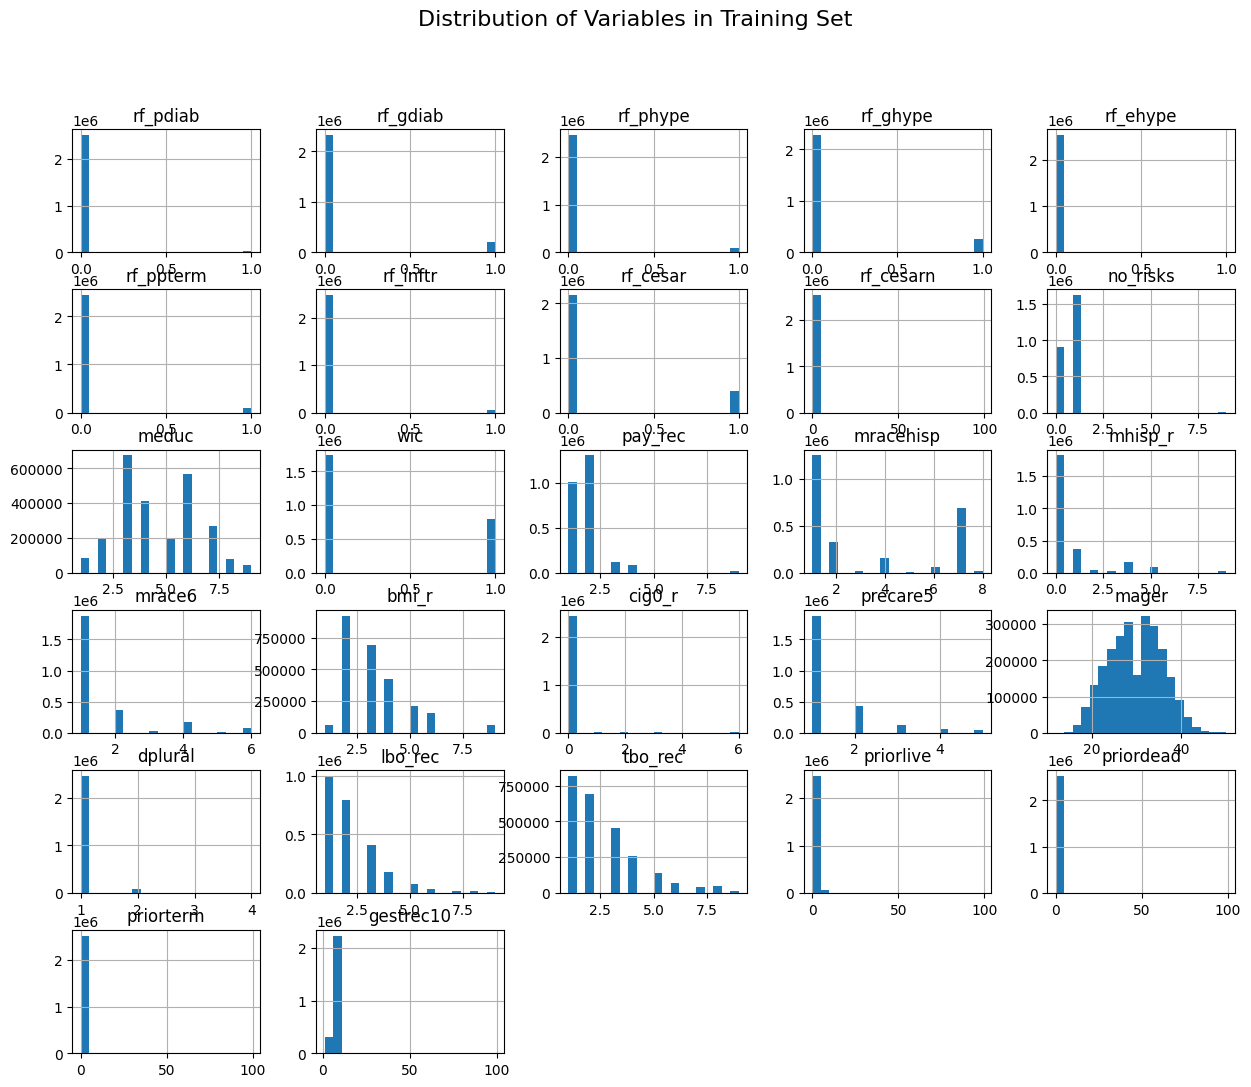

In [11]:
import matplotlib.pyplot as plt

X_train = X_train.apply(pd.to_numeric, errors="ignore")

X_train.hist(figsize=(15, 12), bins=20)
plt.suptitle("Distribution of Variables in Training Set", fontsize=16)
plt.show()


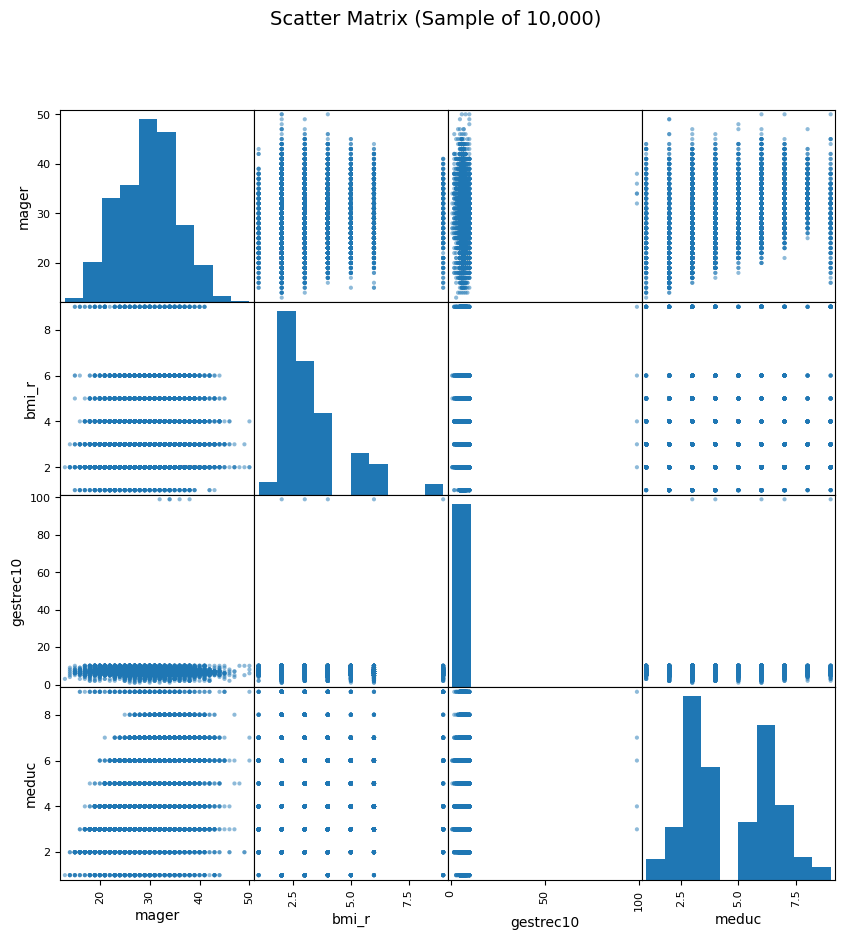

In [12]:
from pandas.plotting import scatter_matrix

sample = X_train.sample(n=10000, random_state=42)

scatter_matrix(sample[["mager", "bmi_r", "gestrec10", "meduc"]],
               figsize=(10, 10), diagonal='hist', alpha=0.5)
plt.suptitle("Scatter Matrix (Sample of 10,000)", fontsize=14)
plt.show()

# full data set- over 3MM cases, takes a really long time to run
#scatter_matrix(X_train[["mager", "bmi_r", "gestrec10", "meduc"]], figsize=(10, 10))

Step 6: Apply transformations to your data

In [13]:
# maternal age
X_train["mager_sq"] = np.square(X_train["mager"])
X_train["mager_cube"] = np.power(X_train["mager"], 3)
X_train["mager_log"] = np.log(X_train["mager"] + 1)
X_train["mager_exp"] = np.exp(X_train["mager"] / X_train["mager"].max())

# gestational age
X_train["gest_sq"] = np.square(X_train["gestrec10"])
X_train["gest_cube"] = np.power(X_train["gestrec10"], 3)
X_train["gest_log"] = np.log(X_train["gestrec10"] + 1)
X_train["gest_exp"] = np.exp(X_train["gestrec10"] / X_train["gestrec10"].max())


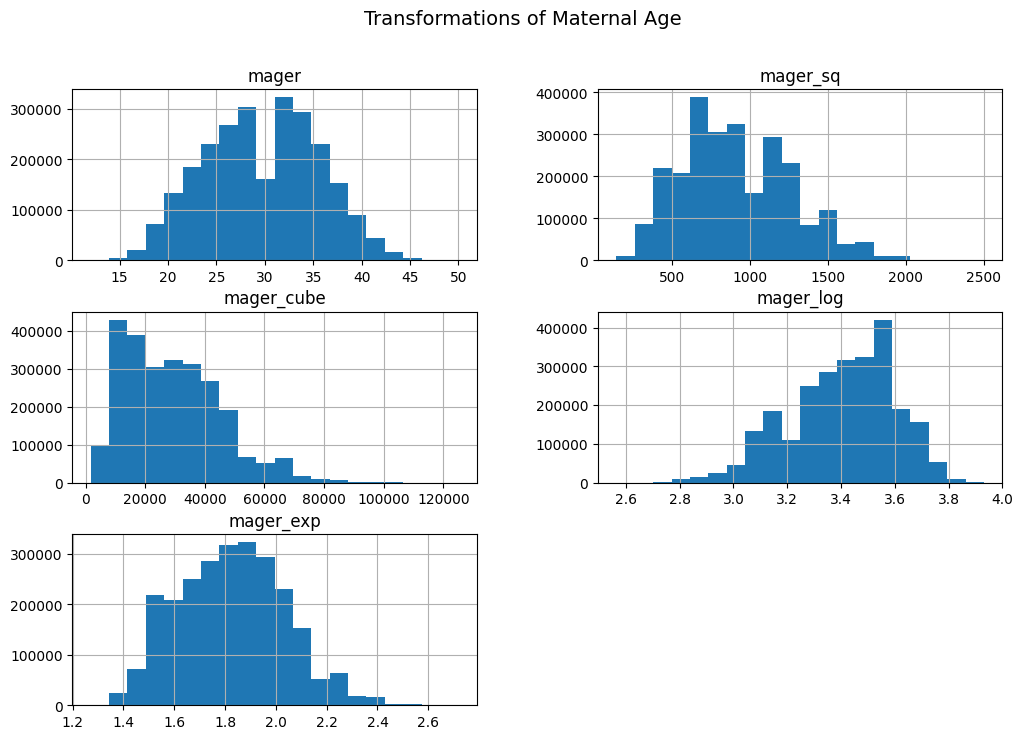

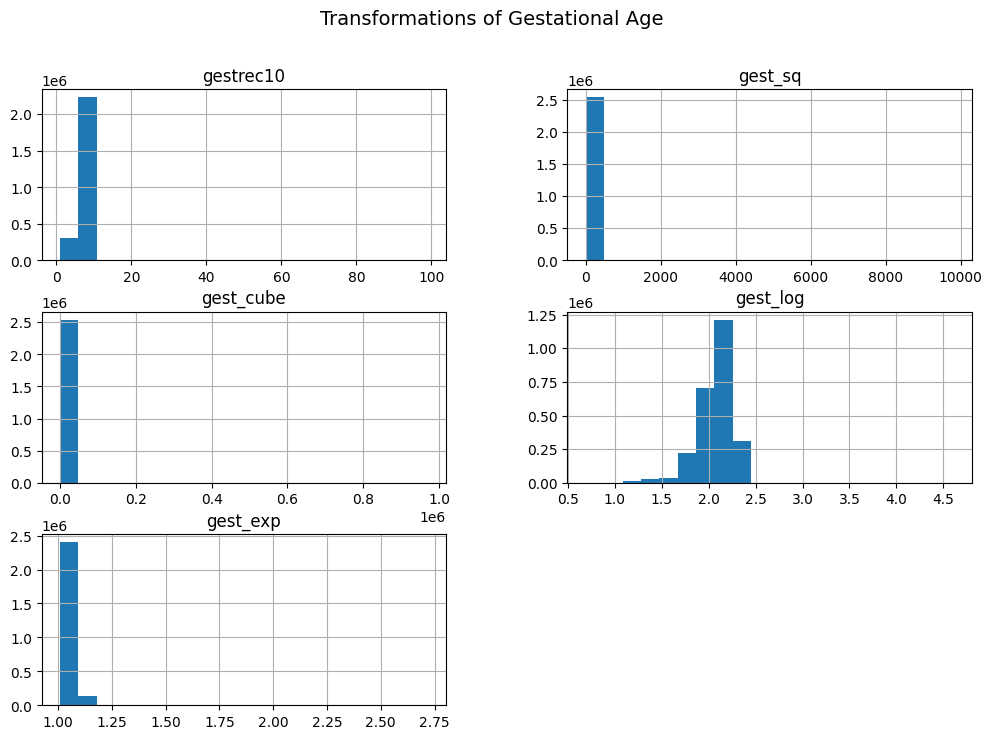

In [14]:
#histograms

X_train[["mager","mager_sq","mager_cube","mager_log","mager_exp"]].hist(
    figsize=(12,8), bins=20
)
plt.suptitle("Transformations of Maternal Age", fontsize=14)
plt.show()

X_train[["gestrec10","gest_sq","gest_cube","gest_log","gest_exp"]].hist(
    figsize=(12,8), bins=20
)
plt.suptitle("Transformations of Gestational Age", fontsize=14)
plt.show()


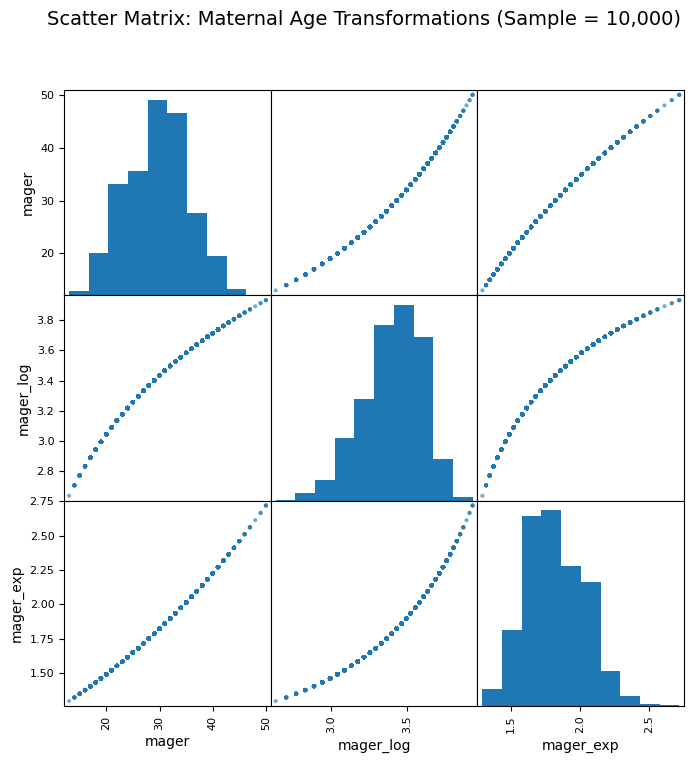

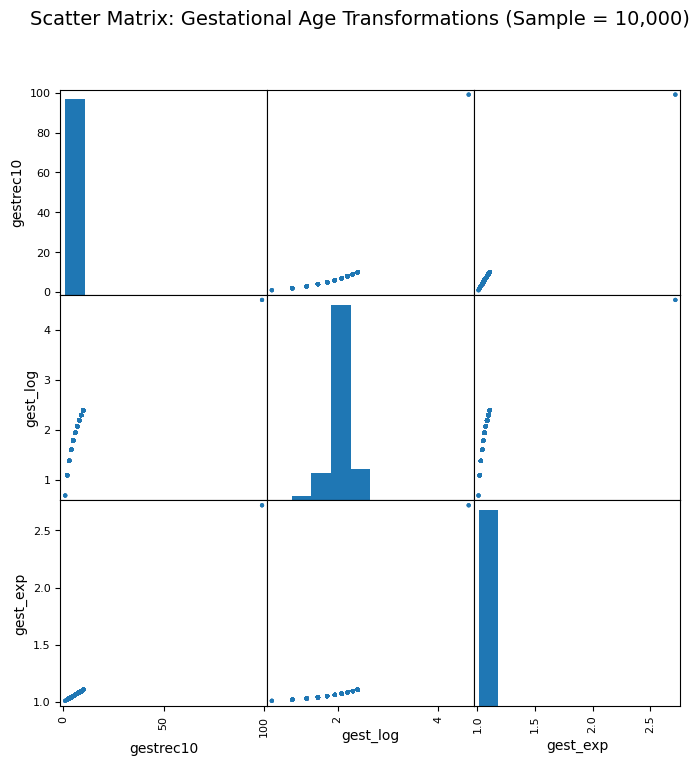

In [15]:
#scatter matrices

sample_df = X_train.sample(n=10000, random_state=42)
scatter_matrix(sample_df[["mager", "mager_log", "mager_exp"]], figsize=(8, 8), alpha=0.6)
plt.suptitle("Scatter Matrix: Maternal Age Transformations (Sample = 10,000)", fontsize=14)
plt.show()


sample_df = X_train.sample(n=10000, random_state=42)
scatter_matrix(sample_df[["gestrec10", "gest_log", "gest_exp"]], figsize=(8, 8), alpha=0.6)
plt.suptitle("Scatter Matrix: Gestational Age Transformations (Sample = 10,000)", fontsize=14)
plt.show()


In [17]:
### TRIMMED CLEAN COPY ###
from google.colab import drive
drive.mount('/content/drive')
df.to_parquet("/content/drive/MyDrive/natality2024_trimmed_clean.parquet", index=False)

Mounted at /content/drive
